# 1. Single Linear Regression - Video Game Sales
## (Using one feature to predict a continuous numerical target)
## https://www.kaggle.com/datasets/ulrikthygepedersen/video-games-sales

In [1]:
#Import Statments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
# Loading video game sales data
df_VideoGame = pd.read_csv('video_games_sales.csv')

# Visualizing the dataframe
df_VideoGame

rank                                              name platform  \
0          1                                        Wii Sports      Wii   
1          2                                 Super Mario Bros.      NES   
2          3                                    Mario Kart Wii      Wii   
3          4                                 Wii Sports Resort      Wii   
4          5                          Pokemon Red/Pokemon Blue       GB   
...      ...                                               ...      ...   
16593  16596                Woody Woodpecker in Crazy Castle 5      GBA   
16594  16597                     Men in Black II: Alien Escape       GC   
16595  16598  SCORE International Baja 1000: The Official Game      PS2   
16596  16599                                        Know How 2       DS   
16597  16600                                  Spirits & Spells      GBA   

         year         genre   publisher  na_sales  eu_sales  jp_sales  \
0      2006.0        Sports    Nintendo     41.49     29.02      3.77   
1      1985.0      Platform    Nintendo     29.08      3.58      6.81   
2      2008.0        Racing    Nintendo     15.85     12.88      3.79   
3      2009.0        Sports    Nintendo     15.75     11.01      3.28   
4      1996.0  Role-Playing    Nintendo     11.27      8.89     10.22   
...       ...           ...         ...       ...       ...       ...   
16593  2002.0      Platform       Kemco      0.01      0.00      0.00   
16594  2003.0       Shooter  Infogrames      0.01      0.00      0.00   
16595  2008.0        Racing  Activision      0.00      0.00      0.00   
16596  2010.0        Puzzle    7G//AMES      0.00      0.01      0.00   
16597  2003.0      Platform     Wanadoo      0.01      0.00      0.00   

       other_sales  global_sales  
0             8.46         82.74  
1             0.77         40.24  
2             3.31         35.82  
3             2.96         33.00  
4             1.00         31.37  
...            ...           ...  
16593         0.00          0.01  
16594         0.00          0.01  
16595         0.00          0.01  
16596         0.00          0.01  
16597         0.00          0.01  

[16598 rows x 11 columns]

## <Markdown style="color : gold">**Visual Feature EDA via DataFrame pretty-print, unique(), isna(), etc..**</Markdown>

### Features:
-     rank : Ordinal Numerical ranking of global_sales placement
-     name : Categorical Nominal  --->  Could be broken up into Video Game Series, with the motivation of some series likely perfroming better than others
-     platform : Categorical Nominal ---> Could add new features such as, 'Hand-held Device', 'Console Generation', 'Platform Company'
-     year : 271 NaN values ---> Have to deal with that via WebScraping the correct data, Imputing, Dropping row... etc. Val range from 1980 - 2020
-     genre :  Categorical Nominal ---> 11 Hard descriptors, 1 value of 'Misc'. 
-     publisher : 58 NaN values ---> Have to deal with that via WebScraping the correct data, Imputing, Dropping row... etc. 578 Unique values
-     na_sales : Ratio Numerical ---> Pareto Distribution (Extreme Right-Tailed), No missing data, But should definitely look into scaling this data. Depending on what kind of error we are trying to optimize will inform us if clipping is reasonably warrented
-     eu_sales : (see na_sales)
-     jp_sales : (see na_sales)
-     other_sales : (see na_sales)
-     global_sales : (see na_sales) [TARGET FEATURE]


## Let's see if we can use a subset of this data to predict the target variable: global_sales

In [3]:
# Exctracting Features from the original df_VideoGame Dataset
df_VideoGameFeatureSubset = df_VideoGame[['platform', 'year', 'genre', 'publisher','na_sales', 'global_sales']]

# Dropping null values from the dataset
df_VideoGameFeatureSubset.dropna(inplace=True)
df_VideoGameFeatureSubset.isnull().sum()

/tmp/ipykernel_1496/2330514909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_VideoGameFeatureSubset.dropna(inplace=True)


platform        0
year            0
genre           0
publisher       0
na_sales        0
global_sales    0
dtype: int64

## <Markdown style="color : red">Major Inacuracies in the process?</Markdown>
### Question: What is *EXTREMELY* bad about the above code block?? 
- Naively removes null values
- Have barely just begun and already trying to modify the dataset. No statistlical thinking just action (Not good if everything in the future depends on this being correct)
- The rows that contain null values:
a. Could be difficult information to collect, and all information within the row is thrown away due to one bad apple
b. Could be extremely important information, think about how the data is distributed. For sales almost all data rows are low values (Pareto distribution), if one data point in the higher percentage of sales is missing, you are throwing away a very valuable / novel row of data. This is especially bad if you could easily find out the missing data through a quick internet search / webscrape
c. In a worst case scenario, could still be naively imputed (via column median or mode)
- not doing a deep copy of the data frame. By not making a deep copy there is now a chance of modifying an object that the user didn't intend to modify

## <Markdown style="color : green">What is good about the code block?</Markdown>
- The dataset is free from null values which could cause headaches if not taken care of. But as discussed above, there are better ways.
- Only removes 2% of the data, quickly solves the null value problem

## <Markdown style="color : yellow">Where did the thought process go wrong?</Markdown>
- (Good idea: handle missing data) 
- (Bad idea: throw away the entire row of data)
- (Better idea: spend more time trying to determine, percisely what the missing data is, and if the data can't be perfectly determined naively impute the data)

In [4]:
# Initialize the labelencoder object
le_videogame = LabelEncoder()

# Save the unencoded feature platform (In case you want to decode later)
df_VideoGame_decoded_platform = df_VideoGameFeatureSubset['platform']

# Override the original platform feature with the label encoded feature
df_VideoGameFeatureSubset['platform'] = le_videogame.fit_transform(df_VideoGameFeatureSubset['platform'])

# Print out the decoded series, platform
df_VideoGame_decoded_platform

/tmp/ipykernel_1496/3575130277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_VideoGameFeatureSubset['platform'] = le_videogame.fit_transform(df_VideoGameFeatureSubset['platform'])


0        Wii
1        NES
2        Wii
3        Wii
4         GB
        ... 
16593    GBA
16594     GC
16595    PS2
16596     DS
16597    GBA
Name: platform, Length: 16291, dtype: object

## <Markdown style="color : cyan">Summarize the above code block</Markdown>
1. Previous coder wanted to numerically encode some categorical values
2. Created an instance of the LabelEncoer class and encoded the categorical nominal feature `platform` as an numerical ordinal value
3. Person wanted to ensure that the label encoding could be looked up later, so saved a copy of the unencoded series in memory


## <Markdown style="color : red">Major Inacuracies in the process?</Markdown>
- Using a label encoder forces a categorical feature that has no order into a numerical ordinal value, artifically imposing order when there is none.
- The fitted label encoder object could reverse the encoding with the method, `inverse_transform()`; keeping around a copy of the original in memory is redundant. 
- Could have added in other features, such as `is_handhled`, `console_generation`, or `manufacturer` 
- Used the same label encoder for other features instead of creating a new instance to `fit_transfrom()` 

## <Markdown style="color : green">What is good about the process?</Markdown>
- Process is reversable, even though they were quick to write over the original data
- Can train a 'bad' model, such that you could compare future improvement 

## <Markdown style="color : yellow">Where did the thought process go wrong?</Markdown>
 - Good: They wanted to map the categroical data to numerical.
 - Bad: They didn't understand they were enforcing order on an unordered collection of items
 - Better: 
 
 a. They could have used `1hot` encoding

 b. Could have created new features

 c. Could have performed more visual EDA to better understand the data

In [5]:
# Save the unencoded feature genre (In case you want to decode later)
df_VideoGame_decoded_genre = df_VideoGameFeatureSubset['genre']

# Override the original genre feature with the label encoded feature
df_VideoGameFeatureSubset['genre'] = le_videogame.fit_transform(df_VideoGameFeatureSubset['genre'])

# Print out the decoded series, genre
df_VideoGame_decoded_genre

/tmp/ipykernel_1496/3503678093.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_VideoGameFeatureSubset['genre'] = le_videogame.fit_transform(df_VideoGameFeatureSubset['genre'])


0              Sports
1            Platform
2              Racing
3              Sports
4        Role-Playing
             ...     
16593        Platform
16594         Shooter
16595          Racing
16596          Puzzle
16597        Platform
Name: genre, Length: 16291, dtype: object

### <Markdown style="color : orange">**See previous**</Markdown>


In [6]:
# Save the unencoded feature publisher (In case you want to decode later)
df_VideoGame_decoded_publisher = df_VideoGameFeatureSubset['publisher']

# Override the original publisher feature with the label encoded feature
df_VideoGameFeatureSubset['publisher'] = le_videogame.fit_transform(df_VideoGameFeatureSubset['publisher'])

# Print out the decoded series, publisher
df_VideoGame_decoded_publisher

/tmp/ipykernel_1496/109776527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_VideoGameFeatureSubset['publisher'] = le_videogame.fit_transform(df_VideoGameFeatureSubset['publisher'])


0          Nintendo
1          Nintendo
2          Nintendo
3          Nintendo
4          Nintendo
            ...    
16593         Kemco
16594    Infogrames
16595    Activision
16596      7G//AMES
16597       Wanadoo
Name: publisher, Length: 16291, dtype: object

### <Markdown style="color : orange">**See previous**</Markdown>

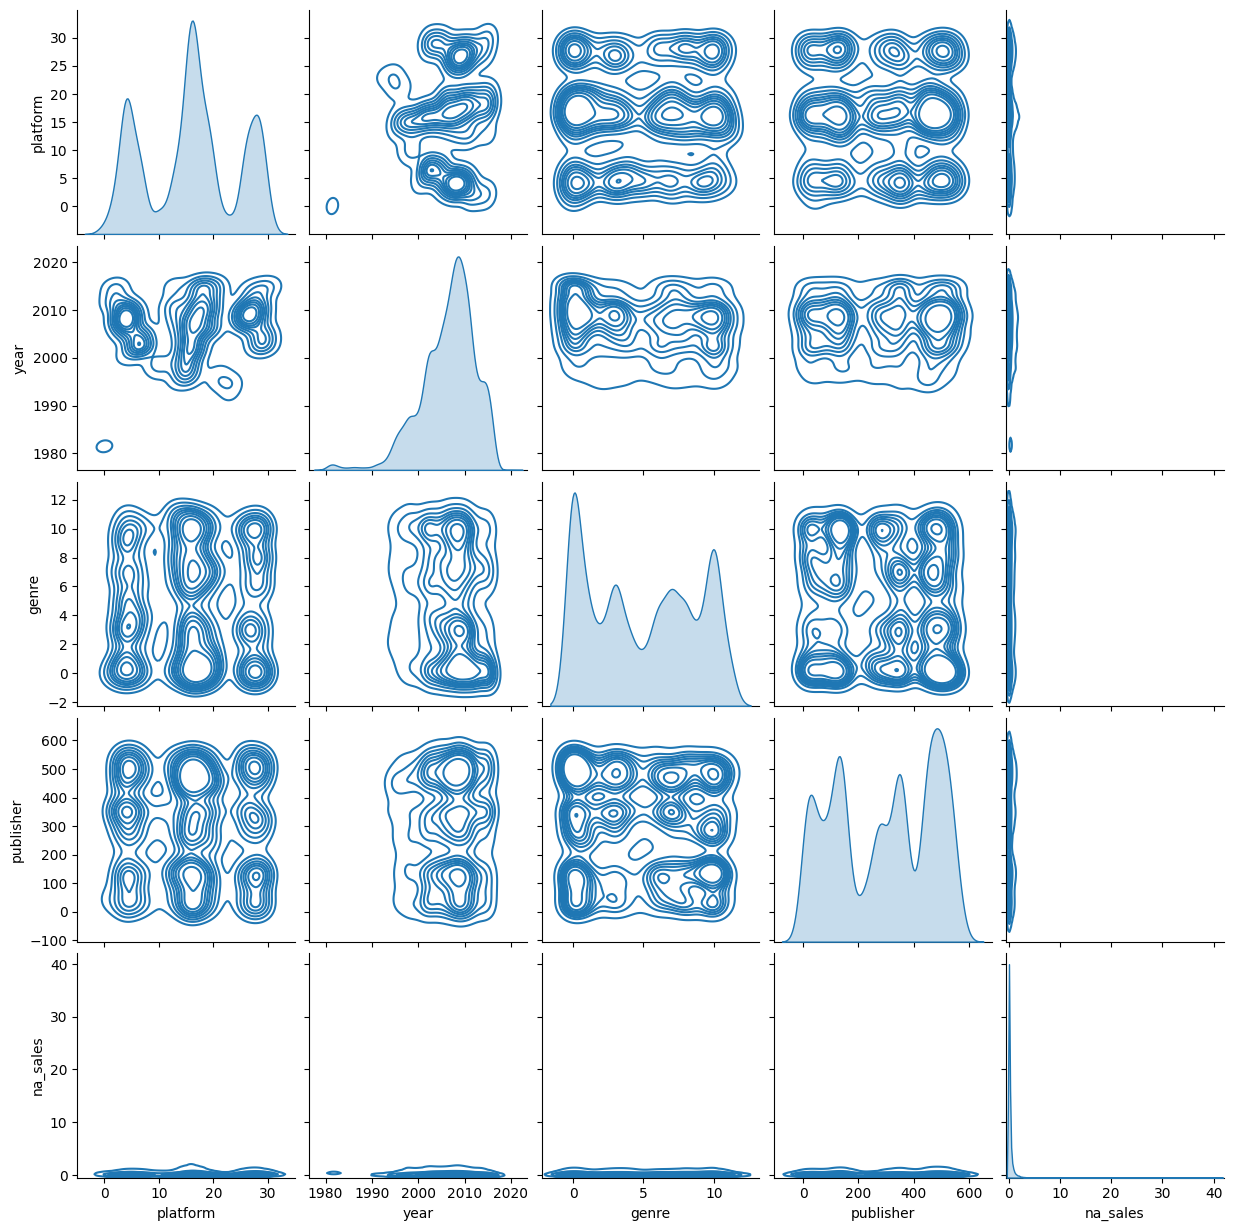

In [7]:
# Feel free to uncomment the chart below, may take a little while to output though
sns.pairplot(df_VideoGameFeatureSubset.drop('global_sales', axis=1), kind='kde')

In [8]:
# View the labelencoded dataframe
df_VideoGameFeatureSubset

platform    year  genre  publisher  na_sales  global_sales
0            26  2006.0     10        359     41.49         82.74
1            11  1985.0      4        359     29.08         40.24
2            26  2008.0      6        359     15.85         35.82
3            26  2009.0     10        359     15.75         33.00
4             5  1996.0      7        359     11.27         31.37
...         ...     ...    ...        ...       ...           ...
16593         6  2002.0      4        269      0.01          0.01
16594         7  2003.0      8        241      0.01          0.01
16595        16  2008.0      6         21      0.00          0.01
16596         4  2010.0      5          8      0.00          0.01
16597         6  2003.0      4        544      0.01          0.01

[16291 rows x 6 columns]

In [9]:
# Normailze platform, year, genre, and publisher
mm_scaler = MinMaxScaler(feature_range=(-1, 1))

df_VideoGameFeatureSubset[['platform', 'year', 'genre', 'publisher']] = mm_scaler.fit_transform(df_VideoGameFeatureSubset[['platform', 'year', 'genre', 'publisher']])
df_VideoGameFeatureSubset

/tmp/ipykernel_1496/2534807158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_VideoGameFeatureSubset[['platform', 'year', 'genre', 'publisher']] = mm_scaler.fit_transform(df_VideoGameFeatureSubset[['platform', 'year', 'genre', 'publisher']])


platform  year     genre  publisher  na_sales  global_sales
0      0.733333  0.30  0.818182   0.248696     41.49         82.74
1     -0.266667 -0.75 -0.272727   0.248696     29.08         40.24
2      0.733333  0.40  0.090909   0.248696     15.85         35.82
3      0.733333  0.45  0.818182   0.248696     15.75         33.00
4     -0.666667 -0.20  0.272727   0.248696     11.27         31.37
...         ...   ...       ...        ...       ...           ...
16593 -0.600000  0.10 -0.272727  -0.064348      0.01          0.01
16594 -0.533333  0.15  0.454545  -0.161739      0.01          0.01
16595  0.066667  0.40  0.090909  -0.926957      0.00          0.01
16596 -0.733333  0.50 -0.090909  -0.972174      0.00          0.01
16597 -0.600000  0.15 -0.272727   0.892174      0.01          0.01

[16291 rows x 6 columns]

## <Markdown style="color : cyan">Summarize the above code block</Markdown>
1. Previous coder wants to `Normalize` the data, such that the features:  `'platform', 'year', 'genre', 'publisher'` can be compared more easily.


## <Markdown style="color : red">Major Inacuracies in the process</Markdown>
- The scaler instance is fitted on the entrie dataset (Not split into training and testing sets), causing data leakage. The training data's scaling is based off of data that will eventually be found in the testing set, leading to better performance on the testing set than when the model is `in-the-wild`
- Doesn't scale all numerical features.
- Still hasn't addressed the extreme right skew in sales

## <Markdown style="color : green">What is good about the process</Markdown>
- For multiple linear regression, having `normalized` input values makes it easier to interpret the trained model's prediction. *assuming all features are normalized and within the same range* 

## <Markdown style="color : yellow">Where did the thought process go wrong</Markdown>
- `Normalizing` feature ranges can help with interpretablity of a trained linear regression model via magnitudes of feature coefficents. 
- However, this person introduces data leakage via `fit_transform` on the entire dataset.
- Additinally, by not normaizing all the feature ranges for a multiple linear regression model, they would lose out on the interpretability offered by `Normalizing`. Leaving only the data leakage, with no benefits.

In [10]:
# Save Checkpoint
df_VideoGameFeatureSubset.to_csv('Game_Data_Cleaned.csv')

In [11]:
# Load the cleaned video game sales data into a dataframe
df_VideoGameCleaned = pd.read_csv('Game_Data_Cleaned.csv')
df_VideoGameCleaned

# Remove the column named 'Unnamed: 0'
df_VideoGameCleaned.drop(['Unnamed: 0'], axis=1, inplace=True)


# print out the dataframe
df_VideoGameCleaned

platform  year     genre  publisher  na_sales  global_sales
0      0.733333  0.30  0.818182   0.248696     41.49         82.74
1     -0.266667 -0.75 -0.272727   0.248696     29.08         40.24
2      0.733333  0.40  0.090909   0.248696     15.85         35.82
3      0.733333  0.45  0.818182   0.248696     15.75         33.00
4     -0.666667 -0.20  0.272727   0.248696     11.27         31.37
...         ...   ...       ...        ...       ...           ...
16286 -0.600000  0.10 -0.272727  -0.064348      0.01          0.01
16287 -0.533333  0.15  0.454545  -0.161739      0.01          0.01
16288  0.066667  0.40  0.090909  -0.926957      0.00          0.01
16289 -0.733333  0.50 -0.090909  -0.972174      0.00          0.01
16290 -0.600000  0.15 -0.272727   0.892174      0.01          0.01

[16291 rows x 6 columns]

## <Markdown style="color : cyan">Summarize the data in df_VideoGameCleaned DataFrame</Markdown>
1. Normalized features, excpet for na_sales and global_sales
2. No Interaction features
3. Categorical features have been transformed into numerical features
4. No complex feature scaling (log, sqrt, etc...)
5. No feature 
6. No outlier handling
7. Very little EDA has been conducted
8. Zero statistical evidence for any actions taken

## <Markdown style="color : cyan">Given the prior information you have seen, is this data ready for model training?</Markdown>
1. Yes - In terms of model training, this data will work. (You'll get a trained model)
2. No - In terms of Data Science and Machnine Learning Engineering, the data is poorly manipulated, and will perform better on the test metrics than they would `in-the-wild`
3. `Note:` Is it fair to use na_sales to predict gloval_sales??

    a. Use it if you got it!! ;) <---- This is not sarcasm. <---- This is not sarcasm : ) Lol

In [12]:
# use the pandas dataframe function called .corr() to quickly check which features most closely 'relate' to the target variable, higher is better
df_VideoGameCleaned.corr()

platform      year     genre  publisher  na_sales  global_sales
platform      1.000000  0.167648  0.026665  -0.017938  0.041976      0.027929
year          0.167648  1.000000 -0.125366   0.029802 -0.091285     -0.074647
genre         0.026665 -0.125366  1.000000  -0.051176  0.018057      0.022215
publisher    -0.017938  0.029802 -0.051176   1.000000  0.005370      0.019368
na_sales      0.041976 -0.091285  0.018057   0.005370  1.000000      0.941269
global_sales  0.027929 -0.074647  0.022215   0.019368  0.941269      1.000000

## <Markdown style="color : cyan">What information is learned from the above process?</Markdown>
1. Strong Positive correlation between na_sales and global sales 

## <Markdown style="color : cyan">Is the original person's comment about '*higher being better*' **true**?</Markdown>
1. I think this depends on what the person means by *higher* and *better*

    a. If by higher they mean x >> 0, then no this is not true

    b. If by higher they mean |x| >> 0 then maybe there is still an argument to be had.

2. What infromation are we led to belive by this correlation matrix?



[]

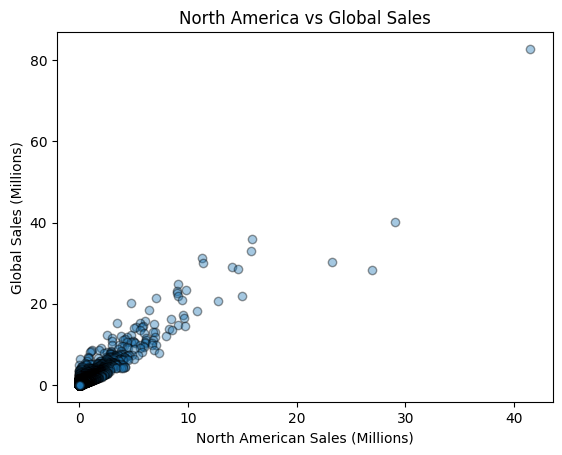

In [13]:
# create a 2D scatter plot to 'eyeball' the relationship between your chosen feature and global_sales
## Assuming you chose to use na_sales to predict global sales... (Not to say that is a good idea or not)

plt.scatter(df_VideoGameCleaned.na_sales, df_VideoGameCleaned.global_sales,  edgecolors='k', alpha=0.4)
plt.xlabel("North American Sales (Millions)")
plt.ylabel("Global Sales (Millions)")
plt.title("North America vs Global Sales")
plt.plot()

In [14]:
# Seperate the Features and the Target
Features = df_VideoGameCleaned.drop('global_sales', axis=1)
Target = df_VideoGameCleaned['global_sales']

In [15]:
# Print the feature dataframe
Features

platform  year     genre  publisher  na_sales
0      0.733333  0.30  0.818182   0.248696     41.49
1     -0.266667 -0.75 -0.272727   0.248696     29.08
2      0.733333  0.40  0.090909   0.248696     15.85
3      0.733333  0.45  0.818182   0.248696     15.75
4     -0.666667 -0.20  0.272727   0.248696     11.27
...         ...   ...       ...        ...       ...
16286 -0.600000  0.10 -0.272727  -0.064348      0.01
16287 -0.533333  0.15  0.454545  -0.161739      0.01
16288  0.066667  0.40  0.090909  -0.926957      0.00
16289 -0.733333  0.50 -0.090909  -0.972174      0.00
16290 -0.600000  0.15 -0.272727   0.892174      0.01

[16291 rows x 5 columns]

In [16]:
# Print the target dataframe
Target

0        82.74
1        40.24
2        35.82
3        33.00
4        31.37
         ...  
16286     0.01
16287     0.01
16288     0.01
16289     0.01
16290     0.01
Name: global_sales, Length: 16291, dtype: float64

In [17]:
# use train_test_split to get your dataset ready for training and testing
X_train, X_test, y_train, y_test = train_test_split(Features, Target, train_size=0.2, random_state=42)

# print out the shape of the trainig and testing, feature and targets
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ',y_train.shape)
print('Shape of y_test: ',y_test.shape)

Shape of X_train:  (3258, 5)
Shape of X_test:  (13033, 5)
Shape of y_train:  (3258,)
Shape of y_test:  (13033,)


In [18]:
# Import the LinearRegression class from sklearn.linear_model
from sklearn.linear_model import LinearRegression

# Initalize the LinearRegression object
lr = LinearRegression()

#!!! Important !!!
# Fit your Linear Regressor on only ** one ** of the features in your X's, 
# HINT: If you have multiple features in your X_train, select your chosen feature for singular linear regression and make a new dataframe

X_single_train = pd.DataFrame(X_train['na_sales'])
X_single_test = pd.DataFrame(X_test['na_sales'])

lr.fit(X_single_train, y=y_train)

# Get your predictions from your fitted model
y_preds = lr.predict(X_single_test)

# use the model's class function .score to calculate the r^2 value
r2_score = lr.score(X_single_test, y_test)
# print out the r2 vaule for the linear regressor
r2_score

0.8658656835077274

In [19]:
# Coefficients and intercept (y = wx + b), where w is the weight, or coefficent of x, and b is the y-intercept
print(f'Coefficients: {lr.coef_}')
print(f'Intercept: {lr.intercept_}')

Coefficients: [1.51616451]
Intercept: 0.12423949384650812


## <Markdown style="color : cyan">What does this information tell us? Using our background knowledge about the features, is this a good model (Hint: plug in some extreme values)</Markdown>
1. global_sales = 1.516 * na_sales + 0.124
2. If we have 0 sales in North America, what does this model tell us about global sales? 

    a. Still predicts that even with $0 sales in North America a video game will recieve $124,000 worth of sales globally, just for existing???  

[]

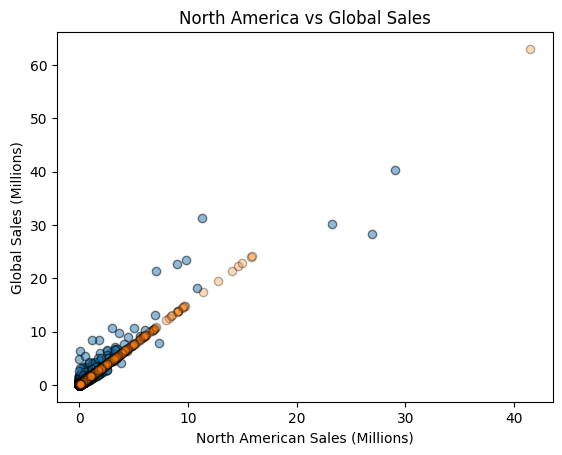

In [20]:
# Use a scatter plot to show how the line passes through the dataset
# You can optionally spilt the train and test set by color, and plot the line by passing X_test, and y_pred
plt.scatter(x=X_single_train, y=y_train, alpha=0.5, edgecolors='k')
plt.scatter(x=X_single_test, y=y_preds, alpha=0.3, edgecolors='k')
plt.xlabel("North American Sales (Millions)")
plt.ylabel("Global Sales (Millions)")
plt.title("North America vs Global Sales")
plt.plot()

### Linear Regression Questions: 

1. What was the final r^2 value of your model? 
2.  What does this tell us? 

- [Your Answer Here]

3. Can we get more performance from this model? 
4. If so, how? If not, why?
- [Your Answer Here]

5. Would it be beneficial to perform multiple linear regresssion? I.e. use several features to predict the target?
6. Why?
- [Your Answer Here]

7. Why is there one feature in particular that tracks so well with the target, global_sales?
- [Your Answer Here]

# 2. Multi Classification - Classify the *"Quality"* variable (3~9) for Wine Data
## Use the numeric features in the wine dataset to predict a 'class'
## https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/data

In [21]:
# Load the wine dataset
df_wine = pd.read_csv('wine_data.csv')
df_wine

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0               11.6             0.580         0.66            2.20   
1               10.4             0.610         0.49            2.10   
2                7.4             1.185         0.00            4.25   
3               10.4             0.440         0.42            1.50   
4                8.3             1.020         0.02            3.40   
...              ...               ...          ...             ...   
20995            9.7             1.020         0.91           50.00   
20996           10.2             0.610         0.88           53.80   
20997           13.4             0.460         1.04           52.10   
20998            6.6             1.030         1.09           25.30   
20999            9.3             0.930         1.32           33.60   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
0          0.074                 10.0                  47.0  1.00080  3.25   
1          0.200                  5.0                  16.0  0.99940  3.16   
2          0.097                  5.0                  14.0  0.99660  3.63   
3          0.145                 34.0                  48.0  0.99832  3.38   
4          0.084                  6.0                  11.0  0.99892  3.48   
...          ...                  ...                   ...      ...   ...   
20995      0.412                114.6                 181.7  1.02085  3.30   
20996      0.250                 62.4                 204.7  1.02776  3.52   
20997      0.449                 63.0                 273.5  1.02618  2.89   
20998      0.138                179.8                 295.0  1.02476  2.94   
20999      0.412                128.7                 290.1  1.02182  3.16   

       sulphates  alcohol  quality  
0           0.57      9.0        3  
1           0.63      8.4        3  
2           0.54     10.7        3  
3           0.86      9.9        3  
4           0.49     11.0        3  
...          ...      ...      ...  
20995       0.89     12.0        9  
20996       1.14      9.7        9  
20997       1.76      9.3        9  
20998       1.54     12.9        9  
20999       1.42     13.0        9  

[21000 rows x 12 columns]

## <Markdown style="color : gold">**Numerical Feature EDA via DataFrame pretty-print, unique(), isna(), etc..**</Markdown>

### Features: All Numerical Interval or Ratio
-     fixed_acidity : Values between 3.8 - 15.9
-     volatile_acidity : Values between 0.08 - 15.9
-     citric_acid : Values between 0.0 - 1.66
-     residual_sugar : Values between 0.6 - 65.8
-     chlorides : Values between 3.8 - 15.9
-     free_sulfur_dioxide : Values between 1.0 - 289.0
-     total_sulfur_dioxide : Values between 6.0 - 440.0
-     density : Values between 0.987 - 1.039
-     pH : Values between 2.72 - 4.01
-     sulphates : Values between 0.22 - 2.0
-     alcohol : Values between 8.0 - 14.9
-     quality : Values between 3 - 9

In [22]:
# this feature will be our target variable
df_wine.quality.unique()

array([3, 4, 5, 6, 7, 8, 9])

In [23]:
df_wine.describe().T

count        mean         std      min         25%  \
fixed_acidity         21000.0    9.797079    2.413919  3.80000    7.600000   
volatile_acidity      21000.0    0.774796    0.365015  0.08000    0.430000   
citric_acid           21000.0    0.793870    0.384833  0.00000    0.410000   
residual_sugar        21000.0   31.289348   19.015391  0.60000    9.800000   
chlorides             21000.0    0.200245    0.124933  0.00900    0.072000   
free_sulfur_dioxide   21000.0  129.442333   77.167262  1.00000   45.000000   
total_sulfur_dioxide  21000.0  229.008762  100.183265  6.00000  150.000000   
density               21000.0    1.009972    0.012032  0.98711    0.997417   
pH                    21000.0    3.158712    0.171371  2.72000    3.030000   
sulphates             21000.0    1.020641    0.408304  0.22000    0.620000   
alcohol               21000.0   11.291716    1.182198  8.00000   10.400000   
quality               21000.0    6.000000    2.000048  3.00000    4.000000   

                           50%        75%        max  
fixed_acidity          10.0000   11.80000   15.90000  
volatile_acidity        0.8300    1.08000    1.58000  
citric_acid             0.8700    1.11000    1.66000  
residual_sugar         37.6000   46.80000   65.80000  
chlorides               0.2050    0.29800    0.61100  
free_sulfur_dioxide   145.8000  194.32500  289.00000  
total_sulfur_dioxide  240.5000  311.62500  440.00000  
density                 1.0122    1.01984    1.03898  
pH                      3.1500    3.27000    4.01000  
sulphates               1.0800    1.36000    2.00000  
alcohol                11.3000   12.20000   14.90000  
quality                 6.0000    8.00000    9.00000

In [24]:
y = df_wine.quality
y

0        3
1        3
2        3
3        3
4        3
        ..
20995    9
20996    9
20997    9
20998    9
20999    9
Name: quality, Length: 21000, dtype: int64

In [25]:
X = df_wine.drop('quality', axis=1)
X

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0               11.6             0.580         0.66            2.20   
1               10.4             0.610         0.49            2.10   
2                7.4             1.185         0.00            4.25   
3               10.4             0.440         0.42            1.50   
4                8.3             1.020         0.02            3.40   
...              ...               ...          ...             ...   
20995            9.7             1.020         0.91           50.00   
20996           10.2             0.610         0.88           53.80   
20997           13.4             0.460         1.04           52.10   
20998            6.6             1.030         1.09           25.30   
20999            9.3             0.930         1.32           33.60   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
0          0.074                 10.0                  47.0  1.00080  3.25   
1          0.200                  5.0                  16.0  0.99940  3.16   
2          0.097                  5.0                  14.0  0.99660  3.63   
3          0.145                 34.0                  48.0  0.99832  3.38   
4          0.084                  6.0                  11.0  0.99892  3.48   
...          ...                  ...                   ...      ...   ...   
20995      0.412                114.6                 181.7  1.02085  3.30   
20996      0.250                 62.4                 204.7  1.02776  3.52   
20997      0.449                 63.0                 273.5  1.02618  2.89   
20998      0.138                179.8                 295.0  1.02476  2.94   
20999      0.412                128.7                 290.1  1.02182  3.16   

       sulphates  alcohol  
0           0.57      9.0  
1           0.63      8.4  
2           0.54     10.7  
3           0.86      9.9  
4           0.49     11.0  
...          ...      ...  
20995       0.89     12.0  
20996       1.14      9.7  
20997       1.76      9.3  
20998       1.54     12.9  
20999       1.42     13.0  

[21000 rows x 11 columns]

## <Markdown style="color : cyan">At this point in the process what should come next?</Markdown>
1. Very detailed visual EDA, 
2. Make a naive model to compare with our future efforts
3. Outlier Detection, Feature Distribution Plots, Clipping
4. Creating New Features, Complex Feature Interations, Feature Selection, 
5. Creating Training, Testing, Validation sets
6. Then Feature scaling .fit() ONLY on Training data, .transform() on everything else

In [26]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler(feature_range=(-1, 1))

X = mm_scaler.fit_transform(X)
X = pd.DataFrame(data=X, columns=df_wine.drop('quality', axis=1).columns)
X

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0           0.289256         -0.333333    -0.204819       -0.950920   
1           0.090909         -0.293333    -0.409639       -0.953988   
2          -0.404959          0.473333    -1.000000       -0.888037   
3           0.090909         -0.520000    -0.493976       -0.972393   
4          -0.256198          0.253333    -0.975904       -0.914110   
...              ...               ...          ...             ...   
20995      -0.024793          0.253333     0.096386        0.515337   
20996       0.057851         -0.293333     0.060241        0.631902   
20997       0.586777         -0.493333     0.253012        0.579755   
20998      -0.537190          0.266667     0.313253       -0.242331   
20999      -0.090909          0.133333     0.590361        0.012270   

       chlorides  free_sulfur_dioxide  total_sulfur_dioxide   density  \
0      -0.784053            -0.937500             -0.811060 -0.472142   
1      -0.365449            -0.972222             -0.953917 -0.526123   
2      -0.707641            -0.972222             -0.963134 -0.634085   
3      -0.548173            -0.770833             -0.806452 -0.567766   
4      -0.750831            -0.965278             -0.976959 -0.544631   
...          ...                  ...                   ...       ...   
20995   0.338870            -0.211111             -0.190323  0.300945   
20996  -0.199336            -0.573611             -0.084332  0.567380   
20997   0.461794            -0.569444              0.232719  0.506458   
20998  -0.571429             0.241667              0.331797  0.451706   
20999   0.338870            -0.113194              0.309217  0.338346   

             pH  sulphates   alcohol  
0     -0.178295  -0.606742 -0.710145  
1     -0.317829  -0.539326 -0.884058  
2      0.410853  -0.640449 -0.217391  
3      0.023256  -0.280899 -0.449275  
4      0.178295  -0.696629 -0.130435  
...         ...        ...       ...  
20995 -0.100775  -0.247191  0.159420  
20996  0.240310   0.033708 -0.507246  
20997 -0.736434   0.730337 -0.623188  
20998 -0.658915   0.483146  0.420290  
20999 -0.317829   0.348315  0.449275  

[21000 rows x 11 columns]

## <Markdown style="color : red">In the above cell, is the data ready for scaling?</Markdown>
- Nope, we just introduced data leakage

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=1)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ',X_test.shape)
print('Shape of y_train: ',y_train.shape)
print('Shape of y_test: ',y_test.shape)

Shape of X_train:  (16800, 11)
Shape of X_test:  (4200, 11)
Shape of y_train:  (16800,)
Shape of y_test:  (4200,)


## <Markdown style="color : gold">What kind of algroithms should use for an initial prediction?</Markdown>
### - Should we use a supervised, unsupervised, or semi-supervised model type?
- Supervised. If you have access to the correct answer, use it.

### - At this point what kinds of ways can we make predictions? 
- Classification - Treating the categories as Numerical Ordinal 
- Regression - Treating the categories as Numerical Continuous, have to handle a 'data imbalance' differently in this situation ---> scaling the `target` value may be a way to handle

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Initialize and train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

Accuracy: 0.6261904761904762
              precision    recall  f1-score   support

           3       0.59      0.65      0.62       633
           4       0.59      0.58      0.59       593
           5       0.77      0.62      0.69       611
           6       0.68      0.74      0.71       594
           7       0.75      0.51      0.60       612
           8       0.56      0.59      0.58       575
           9       0.53      0.69      0.60       582

    accuracy                           0.63      4200
   macro avg       0.64      0.63      0.63      4200
weighted avg       0.64      0.63      0.63      4200



## <Markdown style="color : cyan">Summarize the above Code block and Output:</Markdown>
1. Immediatley jumps straight for a medium complexity model, leaving no room for a baseline weaklearner model to compare our perfromance, and wasting compute time and money.
2. Untuned RandomForestClassifier with a randomstate for reproducability
3. Precision seems to be highest in around the center of the data, could be from small N ---> I.e. could be investigated using hypothesis testing to determine if there is any truth to the observation
4. Recall seems to be more 'fuzzy'
5. Most classes have good support, ~600 examples per category

## <Markdown style="color : cyan">Is an Accuracy of 0.63 good for 7 classes?</Markdown>
1. (*Hint*: think about what a random guess would be in this instance).
    
    a. a random guess would be correct about 1 in 7 times `~14%`

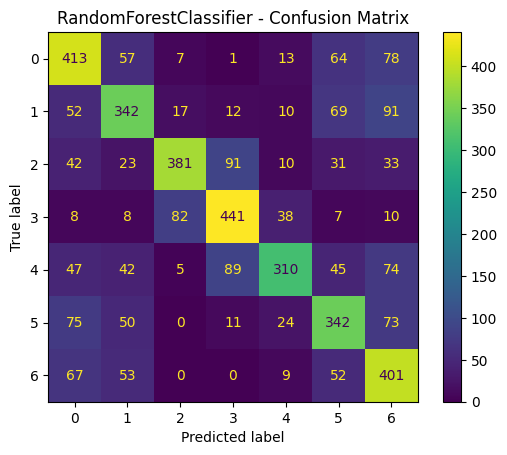

In [29]:
# Calculate the confusion matrix by passing the true y lables, and the predicted y lables
cm = confusion_matrix(y_test, y_pred)

# Use the ConfusionMatrixDisplay from skelearn to get a quick and easy graph
ConfusionMatrixDisplay(cm).plot()
plt.title('RandomForestClassifier - Confusion Matrix')
plt.show()

### Multiclass Classifier Questions
1. Summarize the steps I took to create this multiclass classifier

   -
   -
   -
   -
   -
2. Interpret the Confusion Matrix and Classification Report

3. How could we improve this model? Be specific.

   -
   -
   -
4. What other models might be good to solve this problem?
5. What are the potential downsides of solving this as a classification problem?
6. What are the benifits of solving this as a classification problem?
   

# 3. Binary Classification - Cure The Princess
## https://www.kaggle.com/datasets/unmoved/cure-the-princess

In [30]:
df_Quest = pd.read_csv('Cure_the_princess.csv')
df_Quest

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0                 2.4          18.7            18.4           27.9   
1                 2.1           6.0            15.0           13.3   
2                17.2          13.9            23.8            6.8   
3                 8.4           9.7             6.8           26.9   
4                22.1          10.8            16.4           10.5   
...               ...           ...             ...            ...   
2333              9.4           2.2            15.8            5.9   
2334             12.1           7.6            20.6            5.3   
2335             15.2          33.2             7.2           14.5   
2336              2.0          17.0            33.2           13.2   
2337              6.2           2.6            11.7           23.8   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0            7.9          9.6          18.3          13.2         2.5   
1           15.6         13.1          11.0           5.0         7.2   
2           10.7         15.8          19.4           2.7        15.4   
3            4.6         29.1          14.6          19.7        18.0   
4           22.0         23.4           2.6          18.2        23.8   
...          ...          ...           ...           ...         ...   
2333        29.7         18.7          11.5          13.1        15.3   
2334        18.9         19.1           9.4          11.9        21.8   
2335        16.0         16.7           1.2          32.5        34.5   
2336        29.1         35.5          19.7          30.3        30.7   
2337        11.4          7.3          26.4          18.2        14.0   

      Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  Cured  
0           26.0           10.5            26.2          12.5      0  
1           26.0            1.5            13.3           6.2      0  
2           21.2           11.1            16.6          11.4      1  
3           20.8           13.6            13.9           8.1      1  
4           11.3            5.5            16.8          16.2      0  
...          ...            ...             ...           ...    ...  
2333        22.5           10.1             4.7          13.8      0  
2334        12.0           26.7             8.4          24.4      1  
2335        25.9            3.9            18.0          19.2      1  
2336         4.3           15.7            20.5           2.1      1  
2337        17.1            3.6            21.8           2.5      1  

[2338 rows x 14 columns]

In [31]:
# Envoke the describe command on the dataset
df_Quest.describe()

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
count      2338.000000   2338.000000     2338.000000    2338.000000   
mean         15.365697     10.946749       16.115654      13.627973   
std           8.669969      7.225162        8.372518       7.545244   
min           1.000000      1.000000        1.000000       1.000000   
25%           8.500000      5.300000        9.600000       7.600000   
50%          14.700000      9.500000       15.800000      13.100000   
75%          21.300000     15.575000       22.000000      19.000000   
max          42.100000     34.100000       40.800000      35.800000   

        Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw   Troll Hair  \
count  2338.000000  2338.000000   2338.000000   2338.000000  2338.000000   
mean     15.069504    14.157271     12.328914     14.911206    16.871685   
std       8.349340     7.831476      7.709753      8.132678     9.579027   
min       1.000000     1.000000      1.000000      1.000000     1.000000   
25%       8.625000     7.900000      6.325000      8.400000     8.900000   
50%      14.500000    13.500000     11.200000     14.400000    16.300000   
75%      20.700000    19.500000     16.900000     20.500000    24.000000   
max      40.400000    37.800000     37.300000     39.400000    44.800000   

        Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang        Cured  
count  2338.000000    2338.000000     2338.000000   2338.000000  2338.000000  
mean     14.890590      10.916125       15.371600     12.084003     0.496578  
std       8.014197       7.045195        8.559139      8.047540     0.500095  
min       1.000000       1.000000        1.000000      1.000000     0.000000  
25%       8.800000       5.200000        8.800000      5.600000     0.000000  
50%      14.400000       9.700000       14.800000     10.500000     0.000000  
75%      20.400000      15.375000       21.100000     17.275000     1.000000  
max      39.500000      33.700000       42.000000     37.800000     1.000000

## <Markdown style="color : gold">**Numerical Feature EDA via DataFrame pretty-print, unique(), isna(), etc..**</Markdown>

### Features: Except for Cured, all values are Numerical Interval or Ratio
-     Ingredients : Min 1.0 - Max ~40ish
-     Cured (outcome) : 0 or 1, mostly even split of cure / no cure ---> Mean of 0.4966

[]

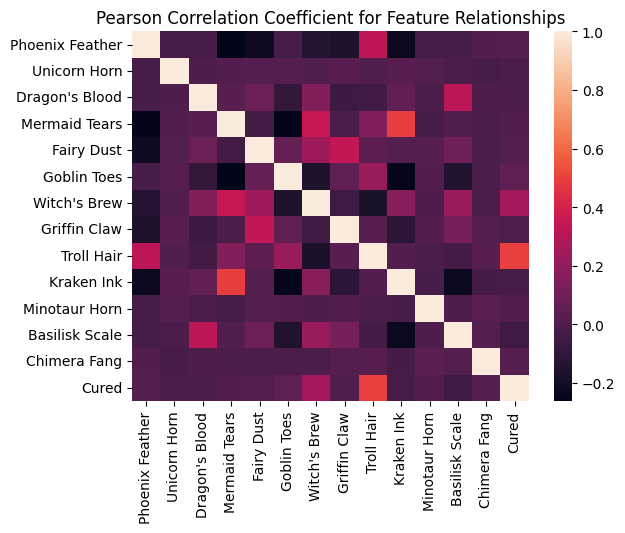

In [32]:
# Plot the values from the .corr() command on a heat map
sns.heatmap(df_Quest.corr())
plt.title('Pearson Correlation Coefficient for Feature Relationships')
plt.plot()

## <Markdown style="color : gold">What Information can we extract from this heatmap??</Markdown>

### Features: 
-     Ingredients : 
-     Cured (outcome) : `Troll Hair`, `Witch's Brew`, `Goblin Toes` seem to have decently strong positive correlation with Cured. 

In [33]:
# Seperate your ingredients (features) from the outcome (target)
X = df_Quest.drop('Cured', axis=1)
X

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0                 2.4          18.7            18.4           27.9   
1                 2.1           6.0            15.0           13.3   
2                17.2          13.9            23.8            6.8   
3                 8.4           9.7             6.8           26.9   
4                22.1          10.8            16.4           10.5   
...               ...           ...             ...            ...   
2333              9.4           2.2            15.8            5.9   
2334             12.1           7.6            20.6            5.3   
2335             15.2          33.2             7.2           14.5   
2336              2.0          17.0            33.2           13.2   
2337              6.2           2.6            11.7           23.8   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0            7.9          9.6          18.3          13.2         2.5   
1           15.6         13.1          11.0           5.0         7.2   
2           10.7         15.8          19.4           2.7        15.4   
3            4.6         29.1          14.6          19.7        18.0   
4           22.0         23.4           2.6          18.2        23.8   
...          ...          ...           ...           ...         ...   
2333        29.7         18.7          11.5          13.1        15.3   
2334        18.9         19.1           9.4          11.9        21.8   
2335        16.0         16.7           1.2          32.5        34.5   
2336        29.1         35.5          19.7          30.3        30.7   
2337        11.4          7.3          26.4          18.2        14.0   

      Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
0           26.0           10.5            26.2          12.5  
1           26.0            1.5            13.3           6.2  
2           21.2           11.1            16.6          11.4  
3           20.8           13.6            13.9           8.1  
4           11.3            5.5            16.8          16.2  
...          ...            ...             ...           ...  
2333        22.5           10.1             4.7          13.8  
2334        12.0           26.7             8.4          24.4  
2335        25.9            3.9            18.0          19.2  
2336         4.3           15.7            20.5           2.1  
2337        17.1            3.6            21.8           2.5  

[2338 rows x 13 columns]

In [34]:
# Seperate out Cured (target)
y = df_Quest.Cured
y

0       0
1       0
2       1
3       1
4       0
       ..
2333    0
2334    1
2335    1
2336    1
2337    1
Name: Cured, Length: 2338, dtype: int64

In [35]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Initalize the MinMaxScaler with feature_range=(-1, 1)
mm_scaler = MinMaxScaler(feature_range=(-1, 1))

# Transform the Ingridents (X) using the MinMaxScaler
X_new = mm_scaler.fit_transform(X=X)
X_scaled = pd.DataFrame(data=X_new, columns=X.columns)
X_scaled

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0           -0.931873      0.069486       -0.125628       0.545977   
1           -0.946472     -0.697885       -0.296482      -0.293103   
2           -0.211679     -0.220544        0.145729      -0.666667   
3           -0.639903     -0.474320       -0.708543       0.488506   
4            0.026764     -0.407855       -0.226131      -0.454023   
...               ...           ...             ...            ...   
2333        -0.591241     -0.927492       -0.256281      -0.718391   
2334        -0.459854     -0.601208       -0.015075      -0.752874   
2335        -0.309002      0.945619       -0.688442      -0.224138   
2336        -0.951338     -0.033233        0.618090      -0.298851   
2337        -0.746959     -0.903323       -0.462312       0.310345   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0      -0.649746    -0.532609     -0.046832     -0.364583   -0.931507   
1      -0.258883    -0.342391     -0.449036     -0.791667   -0.716895   
2      -0.507614    -0.195652      0.013774     -0.911458   -0.342466   
3      -0.817259     0.527174     -0.250689     -0.026042   -0.223744   
4       0.065990     0.217391     -0.911846     -0.104167    0.041096   
...          ...          ...           ...           ...         ...   
2333    0.456853    -0.038043     -0.421488     -0.369792   -0.347032   
2334   -0.091371    -0.016304     -0.537190     -0.432292   -0.050228   
2335   -0.238579    -0.146739     -0.988981      0.640625    0.529680   
2336    0.426396     0.875000      0.030303      0.526042    0.356164   
2337   -0.472081    -0.657609      0.399449     -0.104167   -0.406393   

      Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
0       0.298701      -0.418960        0.229268     -0.375000  
1       0.298701      -0.969419       -0.400000     -0.717391  
2       0.049351      -0.382263       -0.239024     -0.434783  
3       0.028571      -0.229358       -0.370732     -0.614130  
4      -0.464935      -0.724771       -0.229268     -0.173913  
...          ...            ...             ...           ...  
2333    0.116883      -0.443425       -0.819512     -0.304348  
2334   -0.428571       0.571865       -0.639024      0.271739  
2335    0.293506      -0.822630       -0.170732     -0.010870  
2336   -0.828571      -0.100917       -0.048780     -0.940217  
2337   -0.163636      -0.840979        0.014634     -0.918478  

[2338 rows x 13 columns]

## <Markdown style="color : gold">For the third time, why is the above code block bad??</Markdown>

### What will this do in terms of our tests compared to when we try and cure the princess??
- Data leakage

In [36]:
# Seperate the training and testing data using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# print the shape of your datasets
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ',X_test.shape)
print('Shape of y_train: ',y_train.shape)
print('Shape of y_test: ',y_test.shape)

Shape of X_train:  (1870, 13)
Shape of X_test:  (468, 13)
Shape of y_train:  (1870,)
Shape of y_test:  (468,)


In [37]:
# Import Statements
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, RocCurveDisplay

# Initialize and train a LogisticRegressior
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make class predictions
y_preds = lr.predict(X_test) 

# Make probability predicitons, named y_proba
y_proba = lr.predict_proba(X_test)

# Evaluate accuracy using the accuracy_score function from sklearn
acc_score = accuracy_score(y_true=y_test, y_pred=y_preds)
print(acc_score)

# print the classification_report for your logistic 
cr = classification_report(y_true=y_test, y_pred=y_preds)
print(cr)

0.8974358974358975
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       231
           1       0.90      0.90      0.90       237

    accuracy                           0.90       468
   macro avg       0.90      0.90      0.90       468
weighted avg       0.90      0.90      0.90       468



## <Markdown style="color : gold">What does an accuracy of 0.897 mean for us??</Markdown>

### Does this mean that we ***cure*** the princess ~90% of the time? All the metrics are around ~90%
- NO!!! This means that we predicted wether we killed her or saved her correctly ~ 90% of the time.
- 

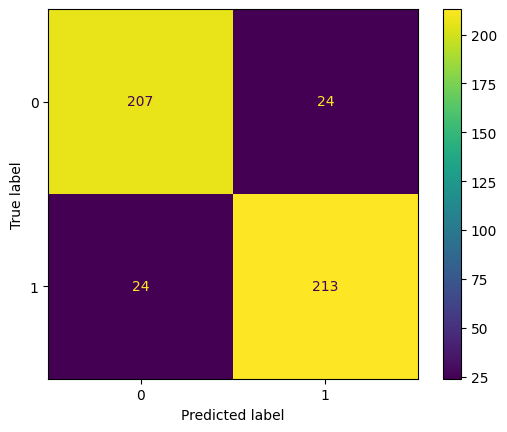

In [38]:
# Create a confusion matrix using the confusion_matrix function, and save it to a variable named cm
cm = confusion_matrix(y_true=y_test, y_pred=y_preds)
# Using ConfusionMatrixDisplay pass your variable named cm that you just created
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()

## <Markdown style="color : gold">Interpret this confusion Matrix</Markdown>
- Decently High Accuracy (True Value Diagonal is High proportion)
- Let's think about what False Positives mean: `false` implies an incrorrect prediction, `positive` implies that we get a `1` value on the prediction. So for a `False Positive` we `incorrectly` predict that we `Save` the princess; i.e. We killed her, but didn't think we would. 
- Let's think about what False Negative mean: `false` implies an incrorrect prediction, `negative` implies that we get a `0` value on the prediction. So for a `False Negative` we `incorrectly` predict that we `Killed` the princess; i.e. We save her, but didn't think we would. 

- Let's think about what a True Positive means: `true` implies a correct prediction, `positive` implies that we get a `1` value on the prediction. So for a `True Positive` we `correctly` predict that we `Save` the princess; i.e. We save her and predicted we save her.
- Let's think about what a True Negative means: `true` implies a correct prediction, `negative` implies that we get a `0` value on the prediction. So for a `True Negative` we `correctly` predict that we `Kill` the princess; i.e. We killed her and predicted we killed her.

## <Markdown style="color : gold">Do we care about False Negative and False Positives equally??</Markdown>

- Absolutely not!! ---> We would rather error towards `false negatives`, ( just extra times we save the princess )
- A `False Positive` only give the king hope that we will save her, but kill her instead

## <Markdown style="color : gold">If the above is No, then what metric should we use to optimize the prediction threshold?</Markdown>
-  Optimize for `Precision` = TP / (TP + FP) <----- i.e. we want FP to be 0

In [39]:
# use the (receiver operating characteristic) roc_curve function to calculate the falsepositive_rate, truepositive_rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])

# use the roc_auc_score to calculate the Area Under the Curve (AUC)
auc = roc_auc_score(y_test, y_proba[:, 1])

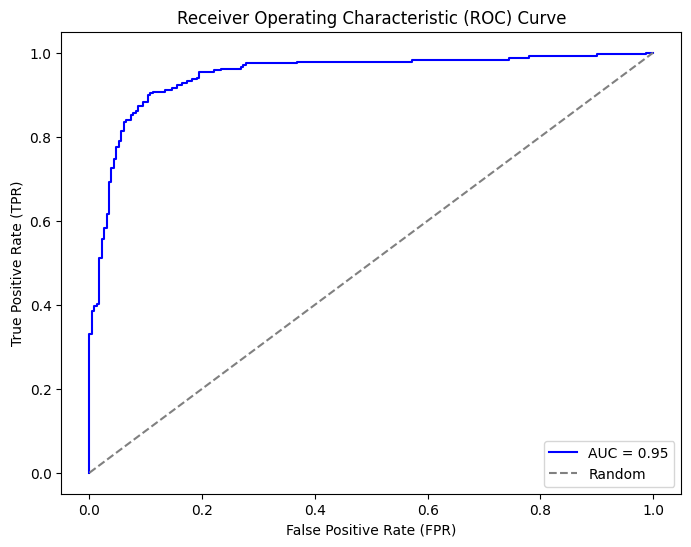

In [40]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(False)
plt.show()

### Cure the Princess
1. What ingredients should you use?
2. How can you be certain that these are the correct ingredients?
3. Can you determine the **exact ratio** of ingredients that maximizes the princess' survival?
4. Should attempt to convience the king that you know to cure the princess, or should you conduct more experiments?
5. *Assuming* that you are ready to cure the princess, convince the king.

# <Markdown style="color : gold">Curing the Princess</Markdown>
## <Markdown style="color : gold">Reworking the solution to give a better prediction and exact ratio of ingredients for the potion</Markdown>

## <Markdown style="color : gold">EDA</Markdown>

In [41]:
df_Quest = pd.read_csv('Cure_the_princess.csv')
df_Quest

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0                 2.4          18.7            18.4           27.9   
1                 2.1           6.0            15.0           13.3   
2                17.2          13.9            23.8            6.8   
3                 8.4           9.7             6.8           26.9   
4                22.1          10.8            16.4           10.5   
...               ...           ...             ...            ...   
2333              9.4           2.2            15.8            5.9   
2334             12.1           7.6            20.6            5.3   
2335             15.2          33.2             7.2           14.5   
2336              2.0          17.0            33.2           13.2   
2337              6.2           2.6            11.7           23.8   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0            7.9          9.6          18.3          13.2         2.5   
1           15.6         13.1          11.0           5.0         7.2   
2           10.7         15.8          19.4           2.7        15.4   
3            4.6         29.1          14.6          19.7        18.0   
4           22.0         23.4           2.6          18.2        23.8   
...          ...          ...           ...           ...         ...   
2333        29.7         18.7          11.5          13.1        15.3   
2334        18.9         19.1           9.4          11.9        21.8   
2335        16.0         16.7           1.2          32.5        34.5   
2336        29.1         35.5          19.7          30.3        30.7   
2337        11.4          7.3          26.4          18.2        14.0   

      Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  Cured  
0           26.0           10.5            26.2          12.5      0  
1           26.0            1.5            13.3           6.2      0  
2           21.2           11.1            16.6          11.4      1  
3           20.8           13.6            13.9           8.1      1  
4           11.3            5.5            16.8          16.2      0  
...          ...            ...             ...           ...    ...  
2333        22.5           10.1             4.7          13.8      0  
2334        12.0           26.7             8.4          24.4      1  
2335        25.9            3.9            18.0          19.2      1  
2336         4.3           15.7            20.5           2.1      1  
2337        17.1            3.6            21.8           2.5      1  

[2338 rows x 14 columns]

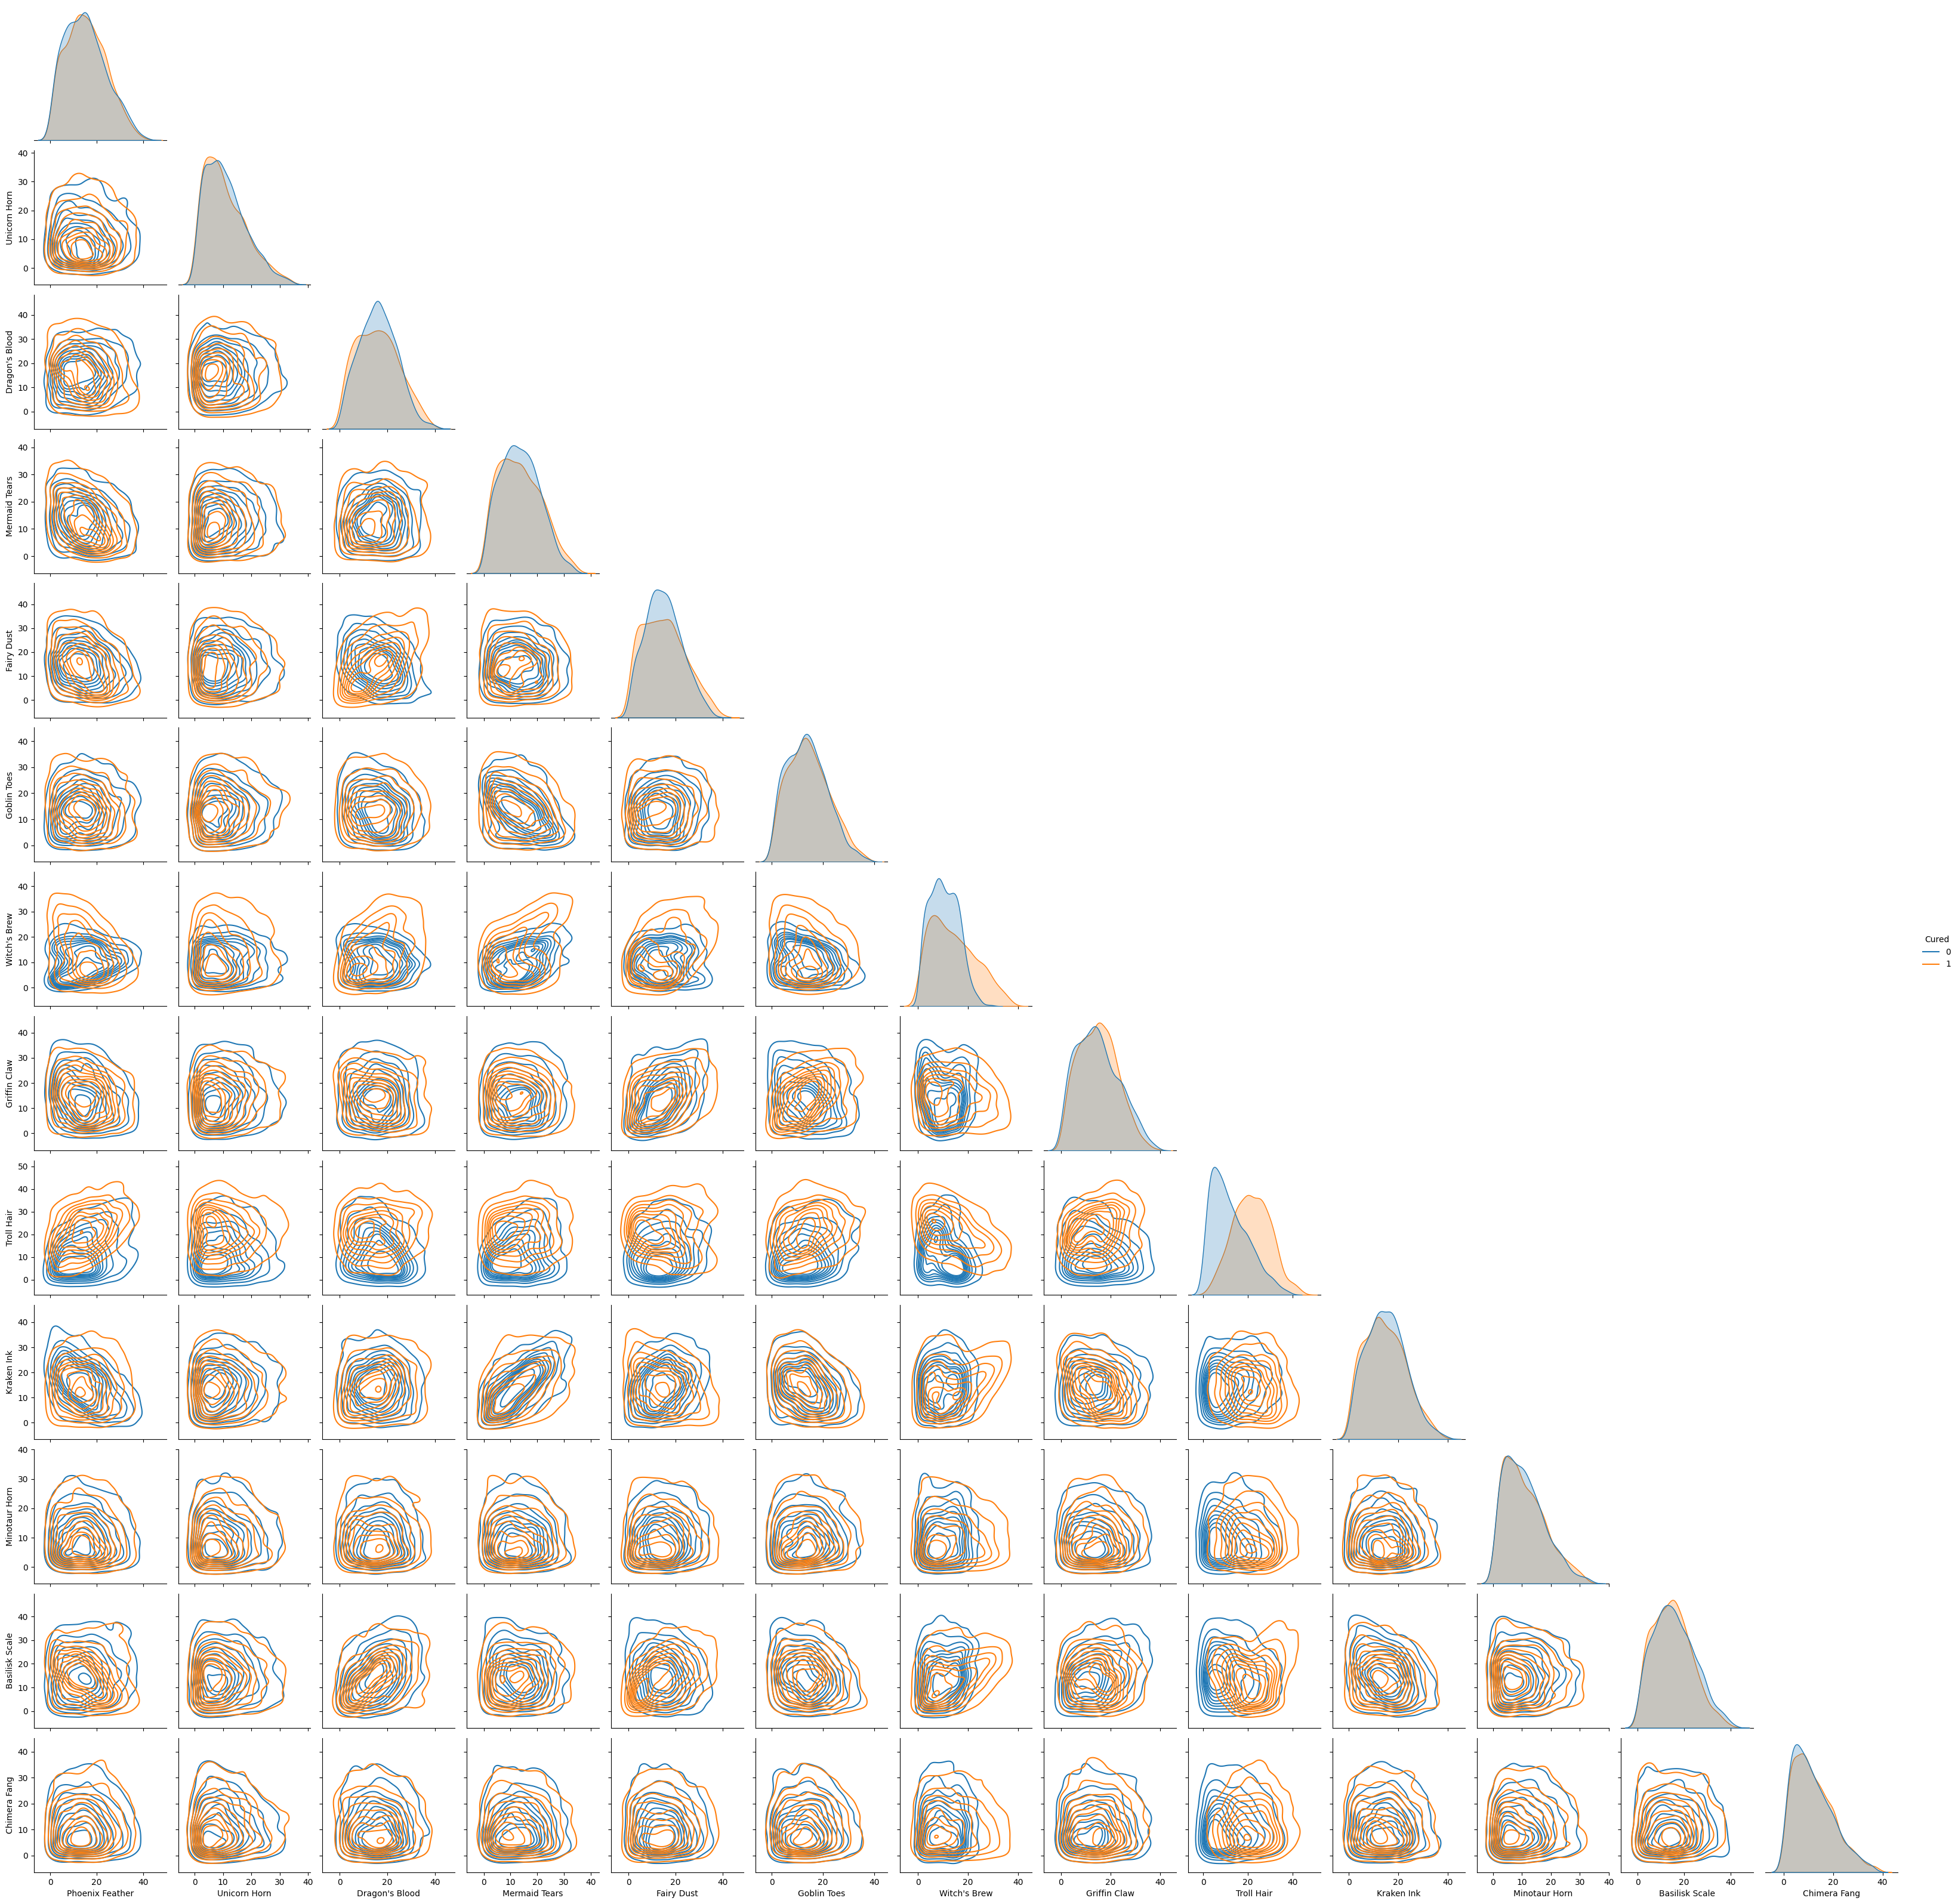

In [42]:
sns.pairplot(df_Quest, hue="Cured", kind='kde', corner=True)

[]

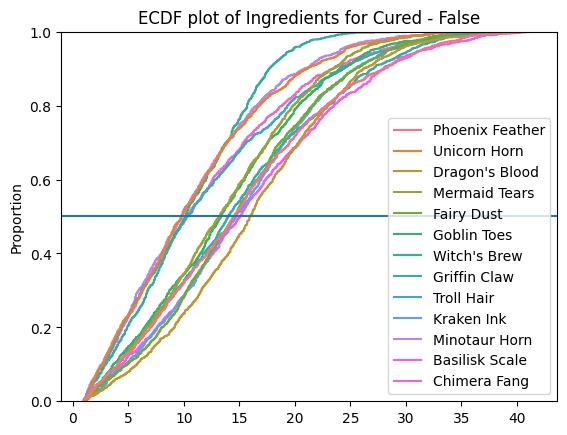

In [43]:
sns.ecdfplot(df_Quest.where(df_Quest.Cured == 0).dropna().drop(['Cured'], axis=1))
plt.title("ECDF plot of Ingredients for Cured - False")

plt.axhline(0.5)
plt.plot()

[]

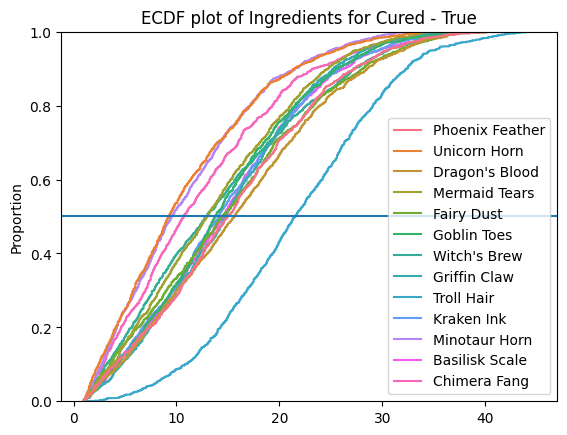

In [44]:
sns.ecdfplot(df_Quest.where(df_Quest.Cured == 1).dropna().drop(['Cured'], axis=1))
plt.title("ECDF plot of Ingredients for Cured - True")

plt.axhline(0.5)
plt.plot()

In [45]:
df_Quest.corr()['Cured']

Phoenix Feather    0.015931
Unicorn Horn      -0.008239
Dragon's Blood    -0.007662
Mermaid Tears      0.009619
Fairy Dust         0.015004
Goblin Toes        0.046314
Witch's Brew       0.245993
Griffin Claw       0.001019
Troll Hair         0.498165
Kraken Ink        -0.022845
Minotaur Horn      0.011329
Basilisk Scale    -0.052436
Chimera Fang       0.022144
Cured              1.000000
Name: Cured, dtype: float64

Text(0.5, 0.98, "ECDF plot for Features with Largest Correlation Magnitudes to 'Cured'")

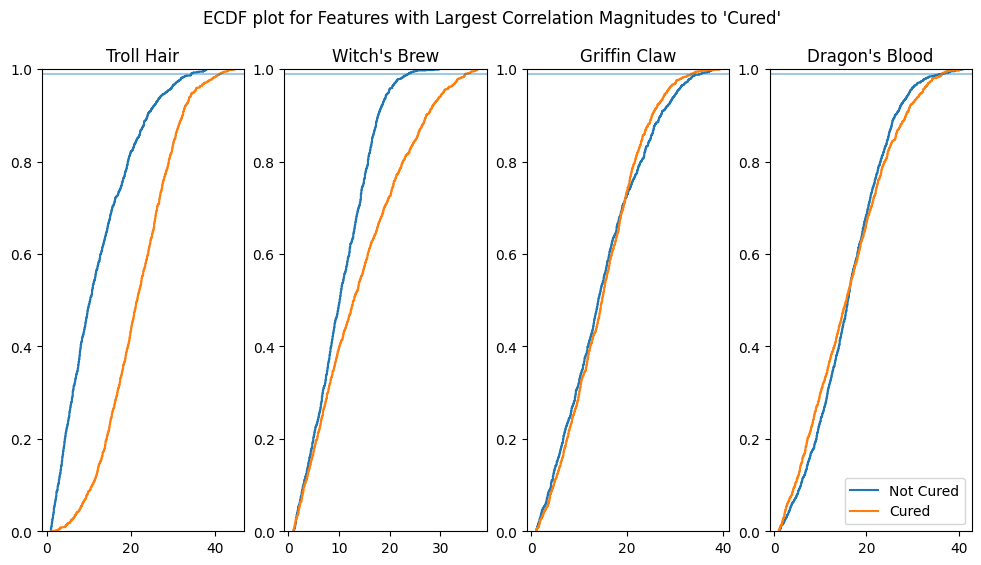

In [46]:
plt.figure(figsize=(12,6))

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

ax1.ecdf(data=df_Quest.where(df_Quest.Cured == 0).dropna(), x='Troll Hair')
ax1.ecdf(data=df_Quest.where(df_Quest.Cured == 1).dropna(), x='Troll Hair')
ax1.axhline(0.990, alpha=0.4)
ax1.set_title('Troll Hair')


ax2.ecdf(data=df_Quest.where(df_Quest.Cured == 0).dropna(), x='Witch\'s Brew')
ax2.ecdf(data=df_Quest.where(df_Quest.Cured == 1).dropna(), x='Witch\'s Brew')
ax2.axhline(0.990, alpha=0.4)
ax2.set_title('Witch\'s Brew')


ax3.ecdf(data=df_Quest.where(df_Quest.Cured == 0).dropna(), x='Griffin Claw', label='Not Cured')
ax3.ecdf(data=df_Quest.where(df_Quest.Cured == 1).dropna(), x='Griffin Claw', label='Cured')
ax3.axhline(0.990, alpha=0.4)
ax3.set_title('Griffin Claw')

ax4.ecdf(data=df_Quest.where(df_Quest.Cured == 0).dropna(), x='Dragon\'s Blood', label='Not Cured')
ax4.ecdf(data=df_Quest.where(df_Quest.Cured == 1).dropna(), x='Dragon\'s Blood', label='Cured')
ax4.axhline(0.990, alpha=0.4)
ax4.set_title('Dragon\'s Blood')

ax4.legend()

plt.suptitle("ECDF plot for Features with Largest Correlation Magnitudes to 'Cured'")

### Shapiro-Wilk test for feature normality (`Bell Shaped Curve`)
- Interpretation: Features are normally distributed

In [47]:
from scipy import stats

# Shapiro statistic for all columns in df_Quest, excluding 'Cured'
# Closer the value is to 1, the more confidence that the feature is normally distributed
for col in df_Quest.columns:
    res = stats.shapiro(df_Quest[col])
    print(col, '     \t', res.statistic)

# Interpretation: all features are `likely` normally distributed except for Cured

Phoenix Feather      	 0.9754138997701032
Unicorn Horn      	 0.939693615262299
Dragon's Blood      	 0.9837200508698932
Mermaid Tears      	 0.9753878017638676
Fairy Dust      	 0.9771230492394223
Goblin Toes      	 0.9766972576513339
Witch's Brew      	 0.9504834984828233
Griffin Claw      	 0.9776552025172014
Troll Hair      	 0.9743887408133103
Kraken Ink      	 0.9800480852782123
Minotaur Horn      	 0.9450203153303552
Basilisk Scale      	 0.9762205564702433
Chimera Fang      	 0.9409510974424751
Cured      	 0.6365999091806379


## <Markdown style="color : gold">Features, Target, and train_test_split</Markdown>

In [48]:
# Seperate your ingredients (features) from the outcome (target)
X = df_Quest.drop('Cured', axis=1)
X

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0                 2.4          18.7            18.4           27.9   
1                 2.1           6.0            15.0           13.3   
2                17.2          13.9            23.8            6.8   
3                 8.4           9.7             6.8           26.9   
4                22.1          10.8            16.4           10.5   
...               ...           ...             ...            ...   
2333              9.4           2.2            15.8            5.9   
2334             12.1           7.6            20.6            5.3   
2335             15.2          33.2             7.2           14.5   
2336              2.0          17.0            33.2           13.2   
2337              6.2           2.6            11.7           23.8   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0            7.9          9.6          18.3          13.2         2.5   
1           15.6         13.1          11.0           5.0         7.2   
2           10.7         15.8          19.4           2.7        15.4   
3            4.6         29.1          14.6          19.7        18.0   
4           22.0         23.4           2.6          18.2        23.8   
...          ...          ...           ...           ...         ...   
2333        29.7         18.7          11.5          13.1        15.3   
2334        18.9         19.1           9.4          11.9        21.8   
2335        16.0         16.7           1.2          32.5        34.5   
2336        29.1         35.5          19.7          30.3        30.7   
2337        11.4          7.3          26.4          18.2        14.0   

      Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
0           26.0           10.5            26.2          12.5  
1           26.0            1.5            13.3           6.2  
2           21.2           11.1            16.6          11.4  
3           20.8           13.6            13.9           8.1  
4           11.3            5.5            16.8          16.2  
...          ...            ...             ...           ...  
2333        22.5           10.1             4.7          13.8  
2334        12.0           26.7             8.4          24.4  
2335        25.9            3.9            18.0          19.2  
2336         4.3           15.7            20.5           2.1  
2337        17.1            3.6            21.8           2.5  

[2338 rows x 13 columns]

In [49]:
# Seperate out Cured (target)
y = df_Quest.Cured
y

0       0
1       0
2       1
3       1
4       0
       ..
2333    0
2334    1
2335    1
2336    1
2337    1
Name: Cured, Length: 2338, dtype: int64

In [50]:
# Seperate the training and testing data using the train_test_split function
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# print the shape of your datasets
print('Shape of X_train: ', X_train.shape)
print('Shape of X_val: ',X_val.shape)
print('Shape of y_train: ',y_train.shape)
print('Shape of y_val: ',y_val.shape)

Shape of X_train:  (1870, 13)
Shape of X_val:  (468, 13)
Shape of y_train:  (1870,)
Shape of y_val:  (468,)


## <Markdown style="color : gold">Now that we have a hold-out, `validation set`. We can *scale* the data *without* introducing `dataleakage`</Markdown>

In [51]:
# Initalize the MinMaxScaler with feature_range=(-1, 1)
mm_scaler = MinMaxScaler(feature_range=(-1, 1))

# Transform the Ingridents (X) using the MinMaxScaler
X_new = mm_scaler.fit_transform(X=X_train)
X_train_scaled = pd.DataFrame(data=X_new, columns=X.columns)
X_train_scaled

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
0           -0.479319     -0.081571       -0.201005      -0.468278   
1            0.654501     -0.812689       -0.608040      -0.105740   
2            0.250608     -0.703927       -0.175879      -0.492447   
3           -0.649635     -0.933535       -0.296482       0.728097   
4           -0.912409     -0.323263       -0.346734       0.117825   
...               ...           ...             ...            ...   
1865        -0.751825     -0.546828       -0.778894       0.148036   
1866        -0.931873     -0.933535       -0.713568      -0.341390   
1867        -0.396594     -0.504532       -0.321608      -0.371601   
1868        -0.124088     -0.003021       -0.336683      -0.226586   
1869         0.576642      0.190332       -0.562814      -0.154079   

      Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
0      -0.405128    -0.157609     -0.972452     -0.531250   -0.369863   
1      -0.246154     0.184783     -0.432507     -0.567708    0.529680   
2      -0.661538    -0.163043     -0.520661     -0.812500   -0.091324   
3       0.179487    -0.989130      0.774105     -0.234375   -0.378995   
4       0.574359     0.586957     -0.195592      0.598958    0.757991   
...          ...          ...           ...           ...         ...   
1865   -0.661538     0.081522     -0.702479      0.156250    0.164384   
1866   -0.717949    -0.923913     -0.895317     -0.963542   -0.726027   
1867   -0.112821    -0.304348     -0.647383     -0.583333    0.100457   
1868   -0.594872    -0.135870     -0.889807     -0.312500    0.191781   
1869   -0.651282    -0.260870     -0.393939     -0.723958    0.415525   

      Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
0      -0.340260      -0.168196       -0.687805     -0.065574  
1      -0.636364      -0.467890       -0.209756     -0.808743  
2      -0.823377      -0.039755        0.278049     -0.338798  
3       0.007792      -0.449541       -0.156098     -0.191257  
4      -0.605195       0.045872        0.629268     -0.459016  
...          ...            ...             ...           ...  
1865   -0.096104      -0.009174       -0.678049      0.043716  
1866   -0.516883      -0.883792       -0.736585     -0.497268  
1867   -0.870130      -0.957187       -0.097561     -0.202186  
1868   -0.127273       0.296636       -0.541463      0.808743  
1869   -0.579221      -0.987768       -0.551220      0.071038  

[1870 rows x 13 columns]

In [52]:
X_val_new = mm_scaler.transform(X=X_val)
X_val_scaled = pd.DataFrame(data=X_val_new, columns=X.columns)
X_val_scaled

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  Fairy Dust  \
0          -0.576642     -0.256798        0.241206      -0.335347   -0.646154   
1          -0.133820     -0.933535        0.201005      -0.915408   -0.082051   
2           0.090024     -0.854985       -0.824121       0.583082   -0.820513   
3           0.055961     -0.371601       -0.798995       0.546828   -0.543590   
4          -0.912409      0.226586        0.432161       0.377644   -0.394872   
..               ...           ...             ...            ...         ...   
463        -0.284672     -0.861027       -0.140704      -0.135952   -0.733333   
464        -0.459854     -0.728097        0.306533      -0.444109    0.071795   
465        -0.547445     -0.589124        0.291457      -0.141994   -0.866667   
466        -0.946472     -0.395770       -0.055276      -0.135952   -0.056410   
467        -0.839416     -0.540785       -0.170854      -0.679758   -0.225641   

     Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  Kraken Ink  \
0       0.266304     -0.415978     -0.947917   -0.872146   -0.698701   
1      -0.266304     -0.465565      0.515625    0.146119    0.548052   
2      -0.494565      0.008264     -0.609375    0.369863    0.111688   
3      -0.581522     -0.559229     -0.197917    0.648402   -0.324675   
4      -0.880435      0.757576     -0.072917   -0.397260   -0.220779   
..           ...           ...           ...         ...         ...   
463    -0.108696     -0.559229     -0.557292   -0.287671   -0.475325   
464    -0.423913      0.344353     -0.203125   -0.502283   -0.693506   
465    -0.152174     -0.410468     -0.296875   -1.000000   -0.402597   
466    -0.978261     -0.851240     -0.755208   -0.360731   -0.584416   
467     0.081522     -0.983471      0.177083   -0.762557   -0.568831   

     Minotaur Horn  Basilisk Scale  Chimera Fang  
0        -0.449541       -0.043902     -0.704918  
1         0.082569       -0.502439      0.010929  
2        -0.278287       -0.560976     -0.415301  
3        -0.669725        0.165854     -0.633880  
4        -0.217125        0.619512     -0.327869  
..             ...             ...           ...  
463      -0.908257       -0.200000      0.786885  
464      -0.987768        0.141463     -0.830601  
465      -0.302752        0.497561     -0.672131  
466       0.290520       -0.790244      0.021858  
467      -0.737003        0.160976     -0.475410  

[468 rows x 13 columns]

In [53]:
# Initialize and train a LogisticRegressior
lr = LogisticRegression(solver='saga', l1_ratio=0.5, class_weight='balanced')
from sklearn.model_selection import cross_validate, TunedThresholdClassifierCV

lr_CrossValidation = cross_validate(
    lr,
    X_train_scaled,
    y_train,
    cv=7,
    scoring=['roc_auc', 'f1'],
    return_train_score=False
)

lr_auc = lr_CrossValidation['test_roc_auc']
lr_f1 = lr_CrossValidation['test_f1']

print(f'LR - AUC: {lr_auc.mean():.3f} (+/- {lr_auc.std():.3f}), F1: {lr_f1.mean():.3f} (+/- {lr_f1.std():.3f})')

lr.fit(X_train_scaled, y_train)

# Make class predictions
y_preds = lr.predict(X_val_scaled) 

# Make probability predicitons, named y_proba
y_proba = lr.predict_proba(X_val_scaled)

# Evaluate accuracy using the accuracy_score function from sklearn
val_accuracy_score = accuracy_score(y_true=y_val, y_pred=y_preds)
print(val_accuracy_score)

# print the classification_report for your logistic 
cr = classification_report(y_true=y_val, y_pred=y_preds)
print(cr)

LR - AUC: 0.932 (+/- 0.015), F1: 0.865 (+/- 0.021)
0.8952991452991453
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       231
           1       0.90      0.89      0.90       237

    accuracy                           0.90       468
   macro avg       0.90      0.90      0.90       468
weighted avg       0.90      0.90      0.90       468



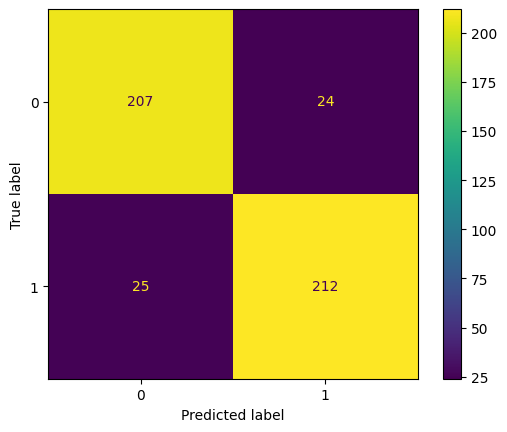

In [54]:
ConfusionMatrixDisplay.from_predictions(y_true=y_val, y_pred=y_preds)

In [55]:
model_thres_results = {}

TunedThreshCV = TunedThresholdClassifierCV(estimator=lr, scoring='precision') 
TunedThreshCV.fit(X=X_train_scaled, y=y_train)

model_thres_results[model] = TunedThreshCV.best_threshold_
print(f'{type(lr).__name__} new threshold: {TunedThreshCV.best_threshold_:.3f}')

LogisticRegression new threshold: 0.990


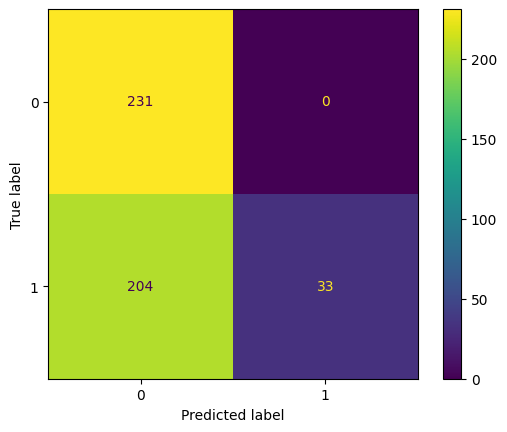

In [56]:
tuned_threshold_predictions = TunedThreshCV.predict_proba(X_val_scaled)[:, 1] > TunedThreshCV.best_threshold_

ConfusionMatrixDisplay.from_predictions(y_true=y_val, y_pred=tuned_threshold_predictions)

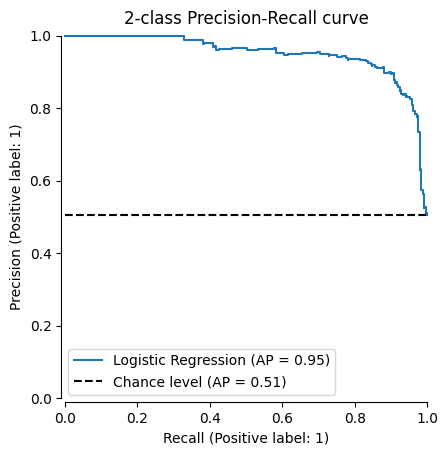

In [57]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(TunedThreshCV, X_val_scaled, y_val, name="Logistic Regression", plot_chance_level=True, despine=True)

_ = display.ax_.set_title("2-class Precision-Recall curve")

In [58]:
TunedThreshCV.estimator.coef_

array([[-3.14873221, -0.12778095,  0.46619942, -3.4582792 , -1.80267721,
        -1.79323354,  4.95069859,  0.60516529,  6.98932027, -0.96589062,
         0.08330538, -1.727524  ,  0.18696262]])

In [59]:
TunedThreshCV.estimator.feature_names_in_

array(['Phoenix Feather', 'Unicorn Horn', "Dragon's Blood",
       'Mermaid Tears', 'Fairy Dust', 'Goblin Toes', "Witch's Brew",
       'Griffin Claw', 'Troll Hair', 'Kraken Ink', 'Minotaur Horn',
       'Basilisk Scale', 'Chimera Fang'], dtype=object)

In [60]:
coeficients = pd.DataFrame(TunedThreshCV.estimator.coef_[0], TunedThreshCV.estimator.feature_names_in_, columns=['Ratio Coef']).T
coeficients

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
Ratio Coef        -3.148732     -0.127781        0.466199      -3.458279   

            Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
Ratio Coef   -1.802677    -1.793234      4.950699      0.605165     6.98932   

            Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
Ratio Coef   -0.965891       0.083305       -1.727524      0.186963

In [61]:
best_recipe = coeficients.where(coeficients>0).replace(np.nan, 0)
best_recipe

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
Ratio Coef              0.0           0.0        0.466199            0.0   

            Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
Ratio Coef         0.0          0.0      4.950699      0.605165     6.98932   

            Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
Ratio Coef         0.0       0.083305             0.0      0.186963

In [62]:
TunedThreshCV.predict_proba(best_recipe)

array([[0., 1.]])

# <Markdown style="color : gold">Now that the process is verified, we can use all of our data (`No train_test_split`)</Markdown>
- i.e. we want to use all of our data, don't leave behind useful information sitting in the validation split

### Training our final model on all available data

In [63]:
FinalModel_thres_results = {}

FinalModel_TunedThreshCV = TunedThresholdClassifierCV(estimator=lr, scoring='precision') 
FinalModel_TunedThreshCV.fit(X=X, y=y)

FinalModel_thres_results[model] = FinalModel_TunedThreshCV.best_threshold_
print(f'{type(lr).__name__} new threshold: {FinalModel_TunedThreshCV.best_threshold_:.3f}')

LogisticRegression new threshold: 1.000


In [64]:
FinalModel_TunedThreshCV.estimator.coef_

array([[-3.14873221, -0.12778095,  0.46619942, -3.4582792 , -1.80267721,
        -1.79323354,  4.95069859,  0.60516529,  6.98932027, -0.96589062,
         0.08330538, -1.727524  ,  0.18696262]])

In [65]:
FinalModel_TunedThreshCV.estimator.feature_names_in_

array(['Phoenix Feather', 'Unicorn Horn', "Dragon's Blood",
       'Mermaid Tears', 'Fairy Dust', 'Goblin Toes', "Witch's Brew",
       'Griffin Claw', 'Troll Hair', 'Kraken Ink', 'Minotaur Horn',
       'Basilisk Scale', 'Chimera Fang'], dtype=object)

In [66]:
FinalModel_coeficients = pd.DataFrame(FinalModel_TunedThreshCV.estimator.coef_[0], FinalModel_TunedThreshCV.estimator.feature_names_in_, columns=['Ratio Coef']).T
FinalModel_coeficients

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
Ratio Coef        -3.148732     -0.127781        0.466199      -3.458279   

            Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
Ratio Coef   -1.802677    -1.793234      4.950699      0.605165     6.98932   

            Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
Ratio Coef   -0.965891       0.083305       -1.727524      0.186963

In [67]:
FinalModel_best_recipe = FinalModel_coeficients.where(FinalModel_coeficients>0).replace(np.nan, 0)
FinalModel_best_recipe

Phoenix Feather  Unicorn Horn  Dragon's Blood  Mermaid Tears  \
Ratio Coef              0.0           0.0        0.466199            0.0   

            Fairy Dust  Goblin Toes  Witch's Brew  Griffin Claw  Troll Hair  \
Ratio Coef         0.0          0.0      4.950699      0.605165     6.98932   

            Kraken Ink  Minotaur Horn  Basilisk Scale  Chimera Fang  
Ratio Coef         0.0       0.083305             0.0      0.186963

In [68]:
FinalModel_TunedThreshCV.predict_proba(FinalModel_best_recipe)

array([[0.01436637, 0.98563363]])

# <Markdown style="color : gold">The Final Logistic Regression Model - `Trained on ALL available data` - predicts the best recipe will: </Markdown>
### <Markdown style="color : limegreen">- Have a 99% Chance of Saving the Princess (2 significant figures)</Markdown>
### <Markdown style="color : red">- And a 1.4% Chance of letting the Princess Die (2 *sig. figs.*)</Markdown>
